In [1]:
from tqdm import *
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
import math
import cv2
from tqdm import tqdm
import torch
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.datasets as datasets
import torch.nn.functional as F
from torchsummary import summary
from torch import nn, optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import pathlib
import os
from shutil import copy
import random
from torchvision import transforms, datasets, utils, models
import torch.nn.functional as Fpi
#from module import VGG
import json
import time
from PIL import Image
import json
import shap
import pytorch_lightning as pl


/usr/bin/miniconda3/envs/f39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torchvision

print(torch.__version__)
print(torch.cuda.is_available())
print(torchvision.__version__)
print(pl.__version__)

import zennit

1.13.1+cu117
True
0.14.1+cu117
2.0.8


##################### Try SHAP #########################

In [4]:
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import time

X,y = shap.datasets.diabetes()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
X_train_summary = shap.kmeans(X_train, 10)

def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(X_test) - y_test)**2))))
    time.sleep(0.5) # to let the print get out before any progress bars

shap.initjs()

In [5]:
from sklearn import linear_model
lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)

print_accuracy(lin_regr.predict)

Root mean squared test error = 58.517171277315626


In [16]:
ex = shap.KernelExplainer(lin_regr.predict, X_train_summary)
shap_values = ex.shap_values(X_test.iloc[0,:])
print(ex.expected_value, shap_values, X_test.iloc[0,:])
print('X_test:', type(X_test), X_test.shape)
shap.force_plot(ex.expected_value, shap_values, X_test.iloc[0,:])

150.97846751460202 [ -0.68190534 -11.49096757  59.35618729  21.67059026  23.56339095
  -8.33972153  -0.61458196  -0.51296344   2.78335312   1.7576458 ] age    0.019913
sex    0.050680
bmi    0.104809
bp     0.070072
s1    -0.035968
s2    -0.026679
s3    -0.024993
s4    -0.002592
s5     0.003709
s6     0.040343
Name: 362, dtype: float64
X_test: <class 'pandas.core.frame.DataFrame'> (89, 10)


100%|██████████| 89/89 [00:03<00:00, 23.69it/s]


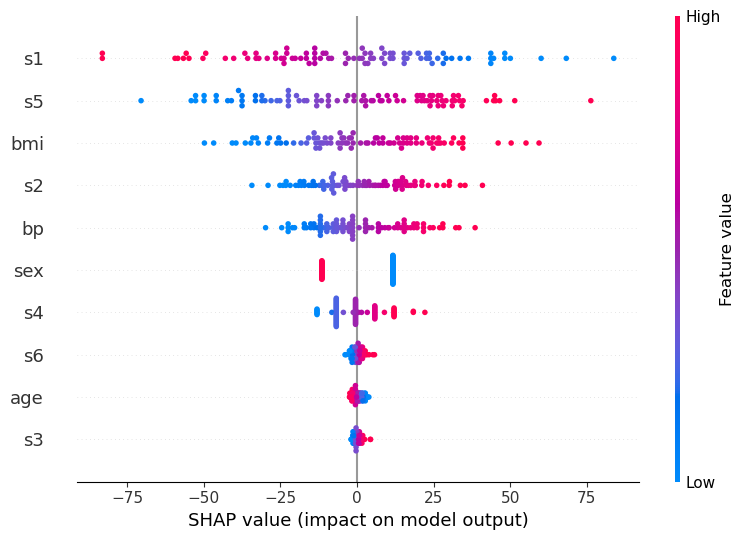

In [9]:
#ex = shap.KernelExplainer(lin_regr.predict, X_train_summary)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

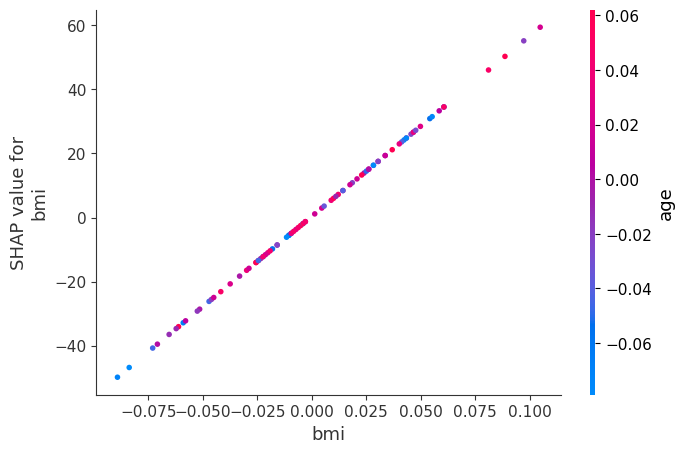

In [10]:
shap.dependence_plot("bmi", shap_values, X_test)

In [11]:
shap.force_plot(ex.expected_value, shap_values, X_test)

################################# LERASLSTM ####################

In [18]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

In [19]:
batch_size = 128
num_epochs = 2
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

100%|██████████| 9912422/9912422 [00:01<00:00, 5003156.63it/s] 


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 904497.21it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 4085329.79it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17009400.69it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301403
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.206583
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.312246
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.093559
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.749582

Test set: Average loss: 0.0047, Accuracy: 8920/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.669787
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.653721
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.456423
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.406750
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.462158

Test set: Average loss: 0.0026, Accuracy: 9371/10000 (94%)



In [26]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:103]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)
print(type(shap_values))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


<class 'list'>


In [28]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

print(len(shap_values))
print(len(shap_numpy))
print(len(test_numpy))

10
10
3


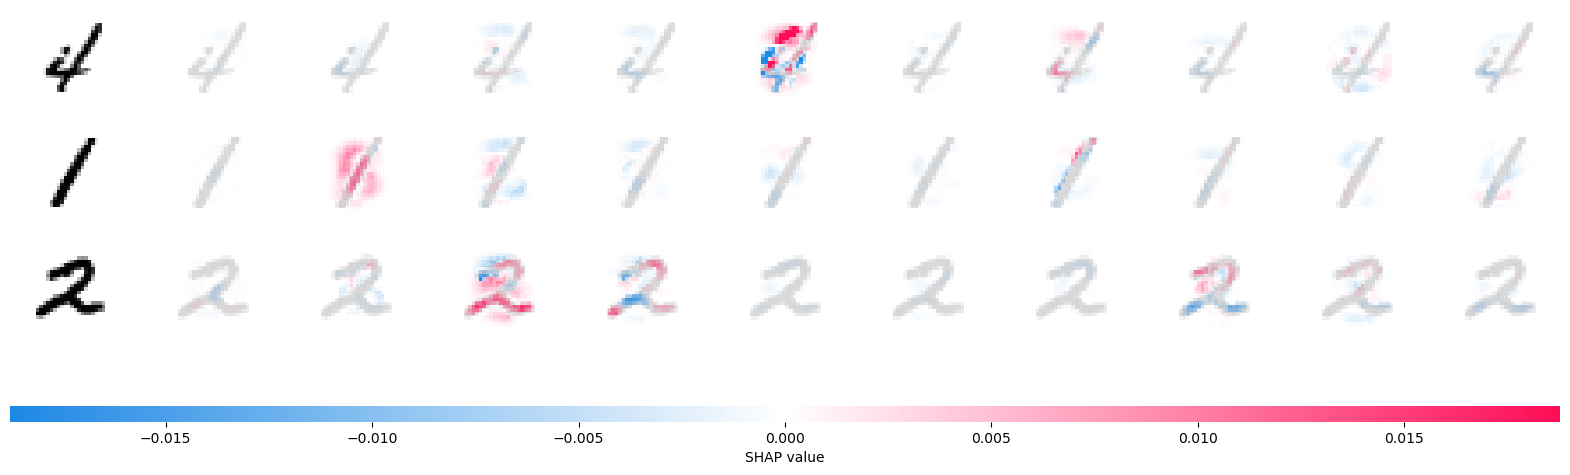

In [22]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

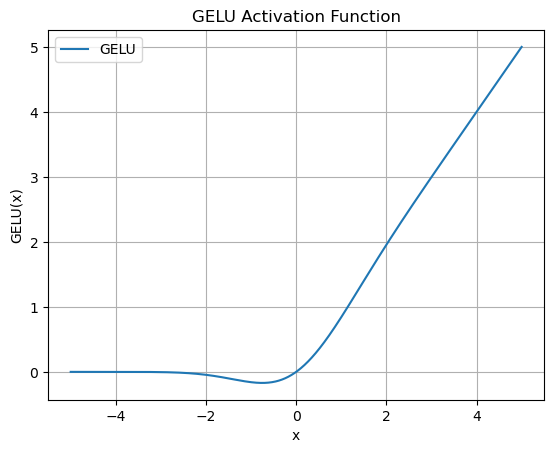

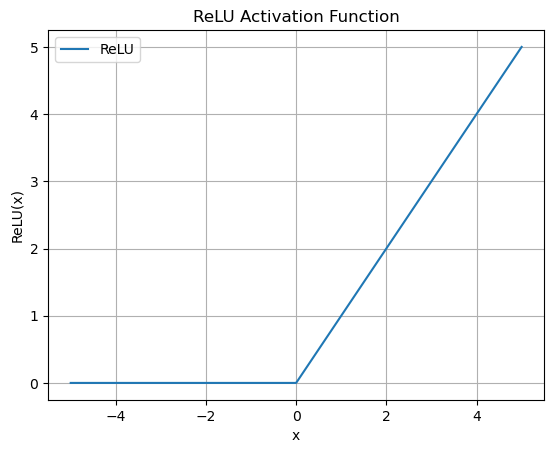

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

x = np.linspace(-5, 5, 1000)
y = gelu(x)

plt.plot(x, y, label='GELU')
plt.title('GELU Activation Function')
plt.xlabel('x')
plt.ylabel('GELU(x)')
plt.grid(True)
plt.legend()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0, x)

x = np.linspace(-5, 5, 1000)
y = relu(x)

plt.plot(x, y, label='ReLU')
plt.title('ReLU Activation Function')
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.grid(True)
plt.legend()
plt.show()



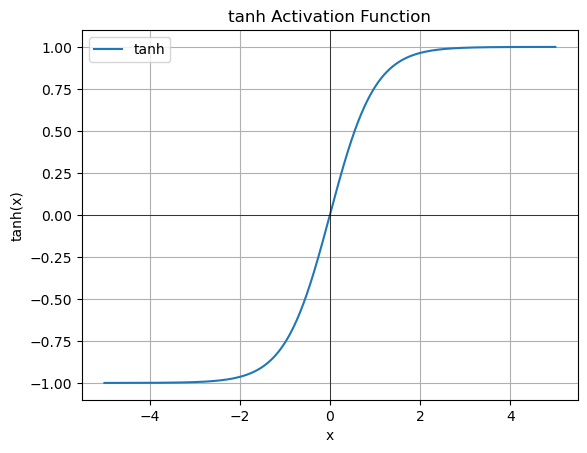

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the tanh function
def tanh(x):
    return np.tanh(x)

# Generate x values
x = np.linspace(-5, 5, 1000)
y = tanh(x)

# Plotting
plt.plot(x, y, label='tanh')
plt.title('tanh Activation Function')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.grid(True)
plt.legend()
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.show()


In [2]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

--2023-10-24 16:22:17--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2023-10-24 16:22:17 (22.0 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]

--2023-10-24 16:22:17--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519 [text/plai

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

/usr/bin/miniconda3/envs/f39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


       Month  Passengers
0    1949-01         112
1    1949-02         118
2    1949-03         132
3    1949-04         129
4    1949-05         121
..       ...         ...
139  1960-08         606
140  1960-09         508
141  1960-10         461
142  1960-11         390
143  1960-12         432

[144 rows x 2 columns] (144, 2)


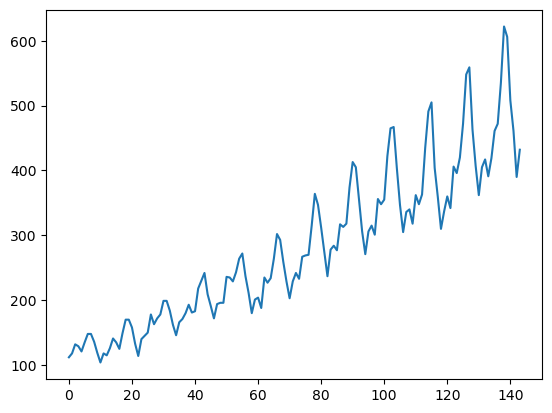

In [12]:
training_set = pd.read_csv('airline-passengers.csv')
#training_set = pd.read_csv('shampoo.csv')
print(training_set, training_set.shape)
training_set = training_set.iloc[:,1:2].values

plt.plot(training_set, label = 'Shampoo Sales Data')
plt.show()

In [5]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [6]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [7]:
num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
     

Epoch: 0, loss: 0.12716
Epoch: 100, loss: 0.01291
Epoch: 200, loss: 0.00321
Epoch: 300, loss: 0.00230
Epoch: 400, loss: 0.00184
Epoch: 500, loss: 0.00174
Epoch: 600, loss: 0.00172
Epoch: 700, loss: 0.00172
Epoch: 800, loss: 0.00171
Epoch: 900, loss: 0.00171


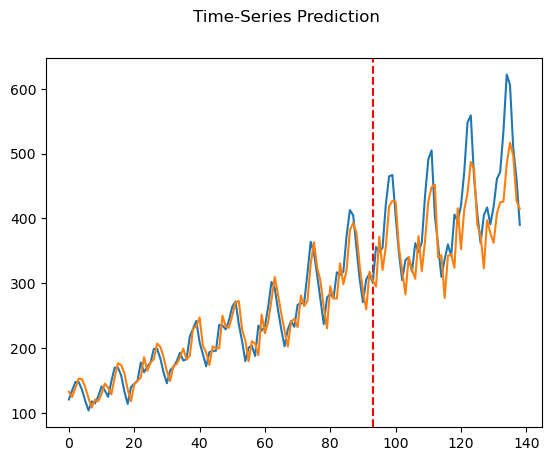

In [8]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()
     

KERAS

In [1]:
# This model training code is directly from:
# https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py

'''Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
# Notes
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

ModuleNotFoundError: No module named 'keras'

SHAP Exsample

In [2]:
import xgboost
import shap

# train XGBoost model
X,y = shap.datasets.adult()
model = xgboost.XGBClassifier(nestimators=100, max_depth=2).fit(X, y)

# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X[:1000])

[16:24:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "nestimators" } are not used.

[16:24:52] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [3]:
print(X.shape, X[:1000].shape, type(X))

(32561, 12) (1000, 12) <class 'pandas.core.frame.DataFrame'>


In [4]:
print(type(shap_values))

<class 'shap._explanation.Explanation'>


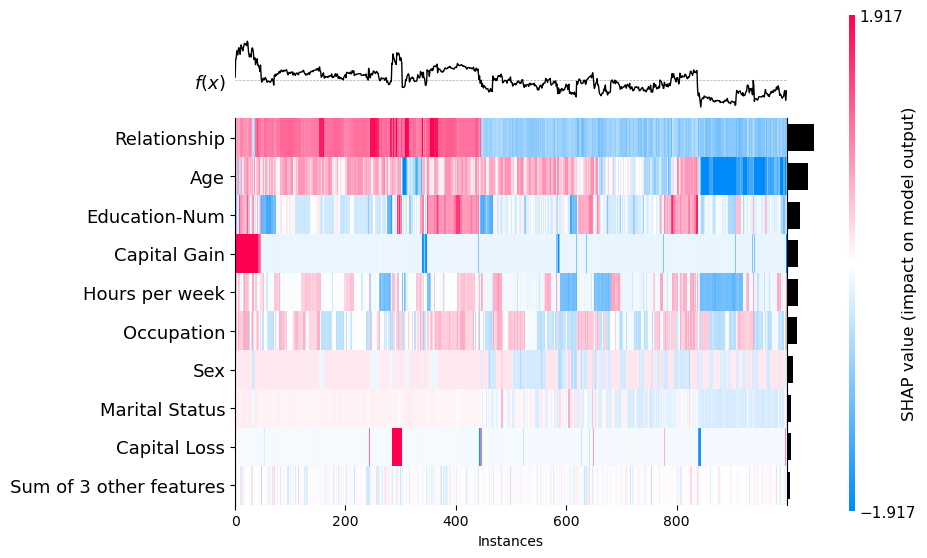

In [5]:
shap.plots.heatmap(shap_values)

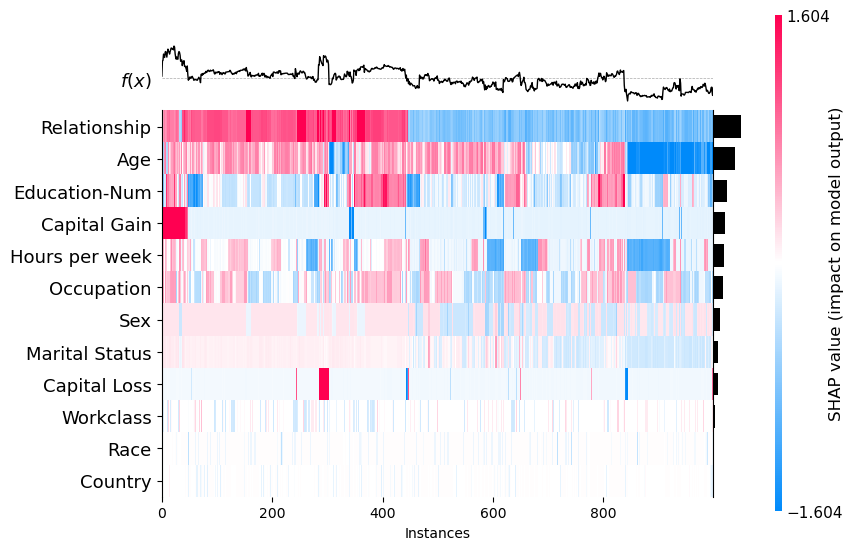

In [6]:
shap.plots.heatmap(shap_values, max_display=12)

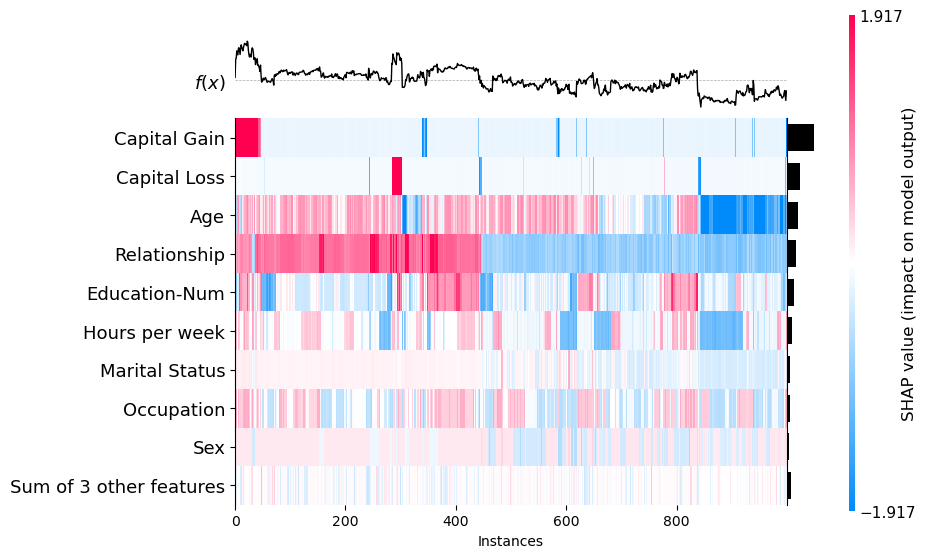

In [7]:
shap.plots.heatmap(shap_values, feature_values=shap_values.abs.max(0))

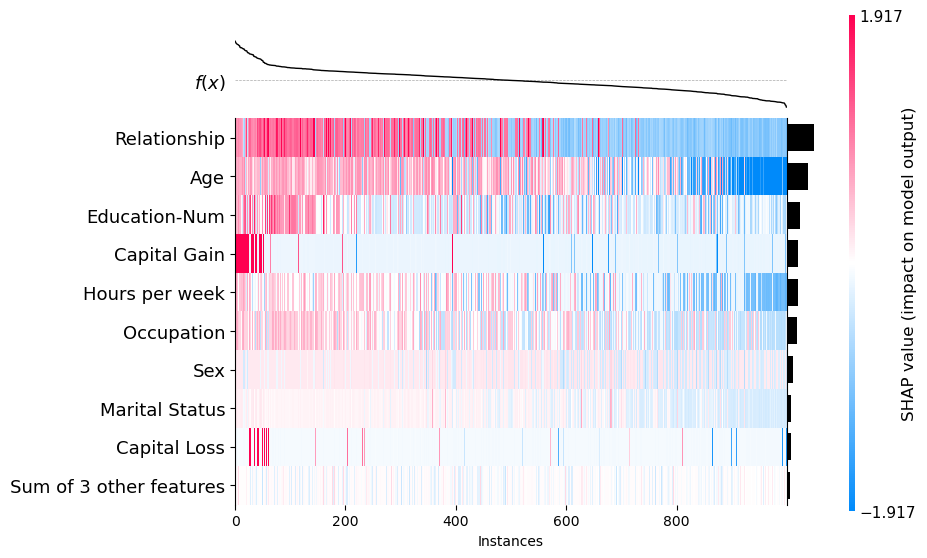

In [8]:
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1))

In [3]:
import time

import numpy as np
from sklearn.model_selection import train_test_split

import shap

X, y = shap.datasets.diabetes()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
X_train_summary = shap.kmeans(X_train, 10)


def print_accuracy(f):
    print(
        "Root mean squared test error = {}".format(
            np.sqrt(np.mean((f(X_test) - y_test) ** 2))
        )
    )
    time.sleep(0.5)  # to let the print get out before any progress bars


shap.initjs()

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


Root mean squared test error = 58.282456670136014


100%|██████████| 89/89 [00:03<00:00, 25.15it/s]


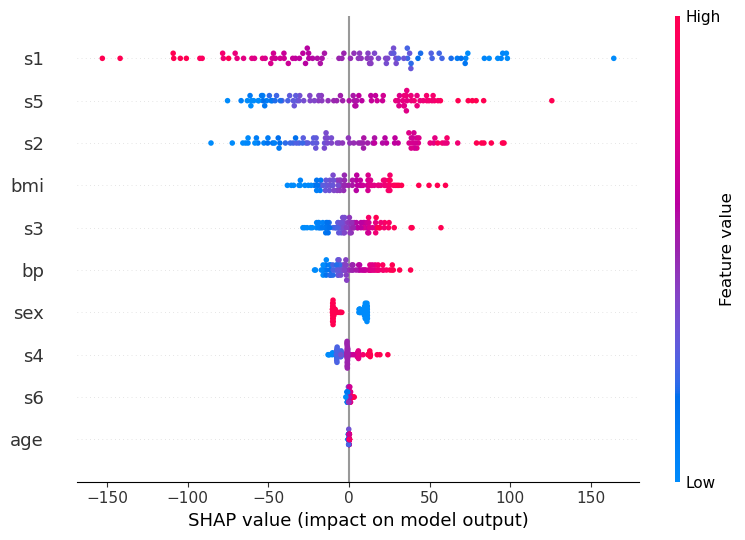

In [4]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(solver="lbfgs", alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0)
nn.fit(X_train, y_train)
print_accuracy(nn.predict)

# explain all the predictions in the test set
explainer = shap.KernelExplainer(nn.predict, X_train_summary)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [10]:
print(X_test.shape, X_test, type(X_test))

(89, 10)           age       sex       bmi        bp        s1        s2        s3  \
362  0.019913  0.050680  0.104809  0.070072 -0.035968 -0.026679 -0.024993   
249 -0.012780 -0.044642  0.060618  0.052858  0.047965  0.029375 -0.017629   
271  0.038076  0.050680  0.008883  0.042529 -0.042848 -0.021042 -0.039719   
435 -0.012780 -0.044642 -0.023451 -0.040099 -0.016704  0.004636 -0.017629   
400 -0.023677 -0.044642  0.045529  0.090729 -0.018080 -0.035447  0.070730   
..        ...       ...       ...       ...       ...       ...       ...   
381 -0.070900  0.050680 -0.089197 -0.074527 -0.042848 -0.025739 -0.032356   
213  0.001751 -0.044642 -0.070875 -0.022885 -0.001569 -0.001001  0.026550   
134 -0.074533 -0.044642  0.043373 -0.033213  0.012191  0.000252  0.063367   
49  -0.041840  0.050680  0.014272 -0.005670 -0.012577  0.006202 -0.072854   
52  -0.052738 -0.044642 -0.009439 -0.005670  0.039710  0.044719  0.026550   

           s4        s5        s6  
362 -0.002592  0.003709  0.040

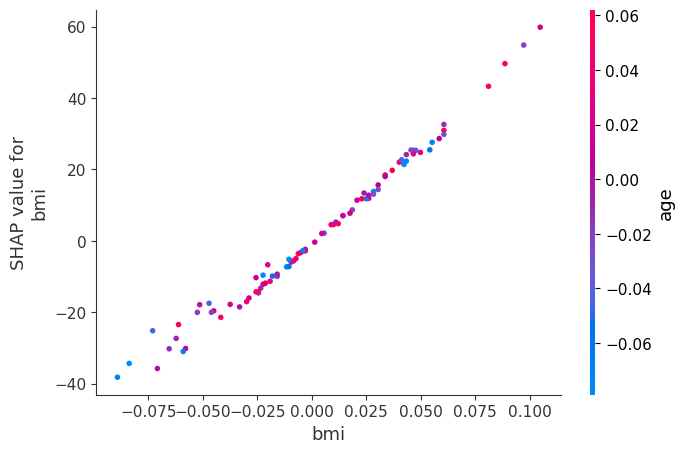

In [5]:
shap.dependence_plot("bmi", shap_values, X_test)

In [6]:
shap.force_plot(explainer.expected_value, shap_values, X_test)

API Try

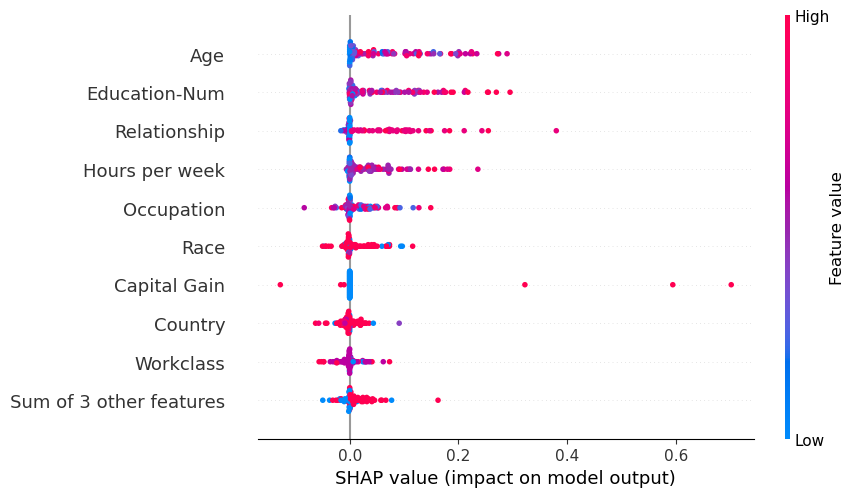

In [11]:
import xgboost

import shap

# train XGBoost model
X, y = shap.datasets.adult()
model = xgboost.XGBClassifier().fit(X.values, y)


# A masking function takes a binary mask vector as the first argument and
# the model arguments for a single sample after that
# It returns a masked version of the input x, where you can return multiple
# rows to average over a distribution of masking types
def custom_masker(mask, x):
    # in this simple example we just zero out the features we are masking
    return (x * mask).reshape(1, len(x))


# compute SHAP values
explainer = shap.Explainer(model.predict_proba, custom_masker)
shap_values = explainer(X[:100])

# plot the SHAP values for the positive class
shap.plots.beeswarm(shap_values[..., 1])

In [12]:
print(X, X.shape, type(X))

        Age  Workclass  Education-Num  Marital Status  Occupation  \
0      39.0          7           13.0               4           1   
1      50.0          6           13.0               2           4   
2      38.0          4            9.0               0           6   
3      53.0          4            7.0               2           6   
4      28.0          4           13.0               2          10   
...     ...        ...            ...             ...         ...   
32556  27.0          4           12.0               2          13   
32557  40.0          4            9.0               2           7   
32558  58.0          4            9.0               6           1   
32559  22.0          4            9.0               4           1   
32560  52.0          5            9.0               2           4   

       Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
0                 0     4    1        2174.0           0.0            40.0   
1              

In [1]:
import torch.nn as nn

class MyCustomModule(nn.Module):
    def __init__(self):
        super(MyCustomModule, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=5)
    
    def my_custom_function(self, x):
        x = nn.ReLU()(x)
        x = self.conv1(x)
        return x

    def forward(self, x):
        x = self.my_custom_function(x)
        x = self.conv2(x)
        return x

/usr/bin/miniconda3/envs/f39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
lets_try= MyCustomModule()
print(lets_try)

MyCustomModule(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1))
)
